In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import glob
import numpy as np
import scipy.io
from keras.utils import to_categorical
import random
import cv2
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
from matplotlib import pyplot as plt
import pandas as pd
from skimage import color
from skimage import io
from skimage.transform import radon, iradon, iradon_sart, rescale
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path = '/content/drive/My Drive/CCE-AIMIA/'

ctScans = scipy.io.loadmat('/content/drive/My Drive/CCE-AIMIA/ctscan_hw1.mat')
ctMasks = scipy.io.loadmat('/content/drive/My Drive/CCE-AIMIA/infmsk_hw1.mat')
(ms,ns,cs)= (ctScans['ctscan']).shape
(mm,nm,cm)= (ctMasks['infmsk']).shape

In [3]:
ctscansarray = []
ctmasksarray = []
for i in range(cm):
    ctscansarray.append((ctScans['ctscan'][:,:,i]))
    ctmasksarray.append((ctMasks['infmsk'][:,:,i]))

In [32]:
class CT:

	def __init__(self, image, max_angle, filter_name):
		"""
		Parameter: input CT slice, max_angle=180 deg, filter_name for Filterback Projection
		"""
		self.image = image
		self.max_angle = max_angle
		self.filter = filter_name

	def process_image(self):
		"""Scale the image and calculate the numbers of projection"""

		image_scaled = rescale(self.image, scale=1, mode='reflect', multichannel=False)
		theta = np.linspace(0.0, self.max_angle, num = 23) # num =45/23 for 4X and 23 for 8X
		num_projection = len(theta)*max(image_scaled.shape)
		
		return image_scaled, theta, num_projection

	def radon_transform(self):
		"""Calculate sinogram using radon transformation"""

		img, theta, __ = self.process_image()
		sinogram = radon(img, theta=theta)

		return sinogram


	def filtered_back_projection(self):
		"""Back projection to reconstruct image from sinogram"""

		__, theta, __ = self.process_image()
		sinogram = self.radon_transform()

		reconstruction = iradon(sinogram, theta=theta, filter_name=self.filter)

		return reconstruction

In [ ]:
sinogram4x = []
reconstructedCT_FBP4x = []
reconstructedCT_SART4x = []
ClassData4x = []
max_angle = 180
# filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
filter_used = "hann"
for i in range(len(ctscansarray)):
  ClassData4x.append(CT(ctscansarray[i],max_angle,filter_used))
for i in range(len(ctscansarray)):
  sinogram4x.append(ClassData4x[i].radon_transform())
  reconstructedCT_FBP4x.append(ClassData4x[i].filtered_back_projection())
  #reconstructedCT_SART.append(ClassData[i].sart())

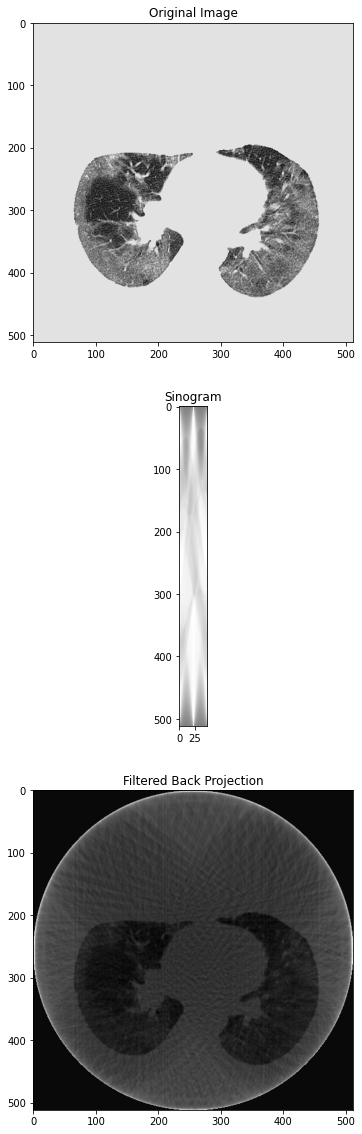

In [6]:
# with max_angle = 180 deg./4x
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(20, 20))
#Plot original image
ax1.set_title("Original Image")
ax1.imshow(ctscansarray[3514], cmap=plt.cm.Greys_r)

#Plot sinogram
ax2.set_title("Sinogram")
ax2.imshow(sinogram4x[3514], cmap=plt.cm.Greys_r)
#Plot reconstructed image
ax3.set_title("Filtered Back Projection")
ax3.imshow(reconstructedCT_FBP4x[3514], cmap=plt.cm.Greys_r)

In [ ]:
sinogram8x = []
reconstructedCT_FBP8x = []
reconstructedCT_SART8x = []
ClassData8x = []
max_angle = 180
# filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
filter_used = "hann"
for i in range(len(ctscansarray)):
  ClassData8x.append(CT(ctscansarray[i],max_angle,filter_used))
for i in range(len(ctscansarray)):
  sinogram8x.append(ClassData8x[i].radon_transform())
  reconstructedCT_FBP8x.append(ClassData8x[i].filtered_back_projection())

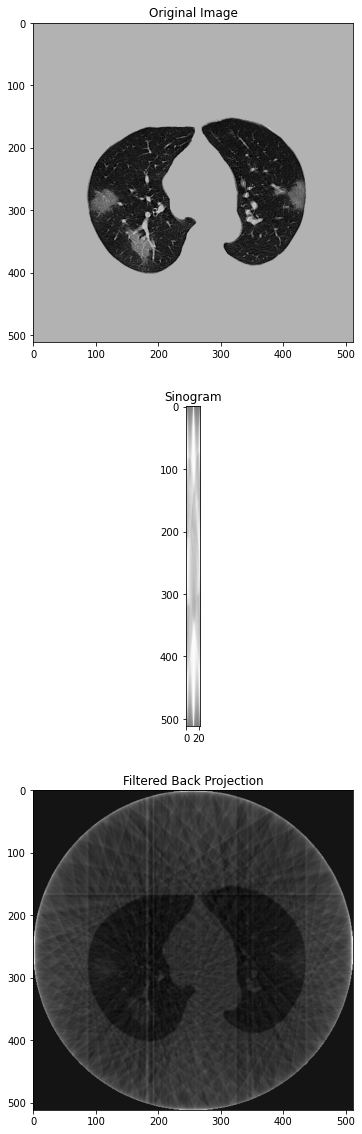

In [39]:
# with max_angle = 180 deg./8x
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(20, 20))
#Plot original image
ax1.set_title("Original Image")
ax1.imshow(ctscansarray[1000], cmap=plt.cm.Greys_r)

#Plot sinogram
ax2.set_title("Sinogram")
ax2.imshow(sinogram8x[1000], cmap=plt.cm.Greys_r)

#Plot reconstructed image
ax3.set_title("Filtered Back Projection")
ax3.imshow(reconstructedCT_FBP8x[1000], cmap=plt.cm.Greys_r)

In [28]:
ctscansrec = []
for i in range(len(reconstructedCT_FBP4x)):
  img1 = cv2.resize(reconstructedCT_FBP4x[i], (128, 128))
  ctscansrec.append(img1)
ctscansrec4X = np.array(ctscansrec)

In [29]:
print(ctscansrec4X.shape)

(331, 128, 128)


In [8]:
ctscanslices = []
ctmaskslices = []
for i in range(cm):
  img1 = cv2.resize(ctscansarray[i], (128, 128))
  ctscanslices.append(img1)
  img2 = cv2.resize(ctmasksarray[i], (128, 128))
  ctmaskslices.append(img2)

In [9]:
ctscans = np.array(ctscanslices)
ctmasks = np.array(ctmaskslices)
print(ctscans.shape)
print(ctmasks.shape)

(3554, 128, 128)
(3554, 128, 128)


In [30]:
masksofRec4x = ctmasks[0:len(ctscansrec4X)]
print(ctscansrec4X.shape)
print(masksofRec4x.shape)
ctscansrec4X = np.expand_dims(ctscansrec4X, axis=3)
masksofRec4x = np.expand_dims(masksofRec4x, axis=3)
print(ctscansrec4X.shape)
print(masksofRec4x.shape)

(331, 128, 128)
(331, 128, 128)
(331, 128, 128, 1)
(331, 128, 128, 1)


In [36]:
ctscansrec8x = []
for i in range(len(reconstructedCT_FBP8x)):
  img1 = cv2.resize(reconstructedCT_FBP8x[i], (128, 128))
  ctscansrec8x.append(img1)
ctscansrec8X = np.array(ctscansrec8x)

In [37]:
masksofRec8x = ctmasks[0:len(ctscansrec8X)]
print(ctscansrec8X.shape)
print(masksofRec8x.shape)
ctscansrec8X = np.expand_dims(ctscansrec8X, axis=3)
masksofRec8x = np.expand_dims(masksofRec8x, axis=3)
print(ctscansrec8X.shape)
print(masksofRec8x.shape)

(1010, 128, 128)
(1010, 128, 128)
(1010, 128, 128, 1)
(1010, 128, 128, 1)


In [10]:
#Reference https://youtu.be/XyX5HNuv-xE
#Reference https://youtu.be/q-p8v1Bxvac
"""
Standard Unet
"""
################################################################
def multi_unet_model(n_classes=3, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])

    model.summary()
    
    return model

In [11]:
#Reference https://youtu.be/XyX5HNuv-xE
"""
code adopted from Digital Srini channel
by Dr. Sreenivas Bhattiprolu Multiclass semantic segmentation using U-Net
"""
n_classes=3 #Number of classes for segmentation
train_images = [] #Capture training image info as a list
train_images = ctscans
train_masks = [] #Capture mask/label info as a list
train_masks = ctmasks
###############################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks, axis=3)
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.20, random_state = 0)
train_masks_cat = to_categorical(y1, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y1.shape[0], y1.shape[1], y1.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

IMG_HEIGHT = X1.shape[1]
IMG_WIDTH  = X1.shape[2]
IMG_CHANNELS = X1.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

history = model.fit(X1, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    
model.save('unet_50_epochs_catXentropy_acc.hdf5')
############################################################

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##################################
#model = get_model()
model.load_weights('unet_50_epochs_catXentropy_acc.hdf5')
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')
#######################################################################

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_171 (Conv2D)            (None, 128, 128, 16  160         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_81 (Dropout)           (None, 128, 128, 16  0           ['conv2d_171[0][0]']             
                                )                                                           

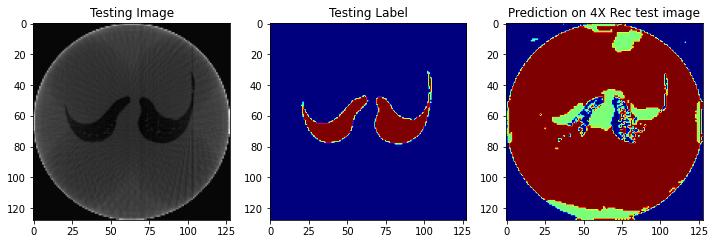

In [45]:
#######################################################################
#Predict on a few images
model = get_model()
model.load_weights('unet_50_epochs_catXentropy_acc.hdf5')  
test_img_number = random.randint(0, len(ctscansrec4X))
test_img = ctscansrec4X[test_img_number]
ground_truth=masksofRec4x[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on 4X Rec test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
print(ctscansrec8X.shape)
print(masksofRec8x.shape)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 128, 128, 16  160         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_54 (Dropout)           (None, 128, 128, 16  0           ['conv2d_114[0][0]']             
                                )                                                           

1/1 [==============================] - 0s 214ms/step


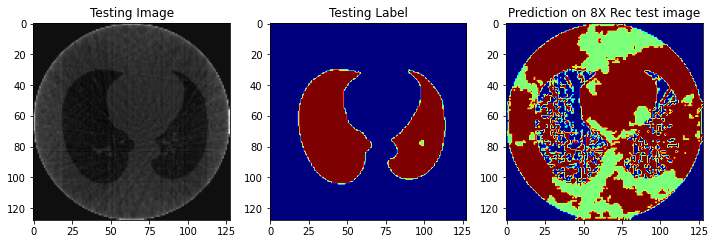

In [42]:
#######################################################################
#Predict on a few images
model = get_model()
model.load_weights('unet_50_epochs_catXentropy_acc.hdf5')  
test_img_number = random.randint(0, len(ctscansrec8X))
test_img = ctscansrec8X[test_img_number]
ground_truth=masksofRec8x[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on 8X Rec test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()